In [5]:
import cv2
import dlib
import numpy
import sys

ImportError: No module named 'dlib'

In [2]:
from matplotlib import pyplot as plt

In [3]:
from PIL import Image
from PIL import ImageDraw

In [4]:
PREDICTOR_PATH = "./shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS + RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)
OVERLAY_POINTS = [LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS, NOSE_POINTS + MOUTH_POINTS,]
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

NameError: name 'dlib' is not defined

In [22]:
PATH1 = "./test2.jpg"
PATH2 = "./4.png"
image1 = cv2.imread(PATH1) ##read image
im1 = cv2.imread(PATH1, cv2.IMREAD_COLOR) ##read image color
image2 = cv2.imread(PATH2) ##raed image
im2 = cv2.imread(PATH2, cv2.IMREAD_COLOR) ##Read image color

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

cv_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
cv_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb1)
plt.show()
plt.imshow(cv_rgb2)
plt.show()

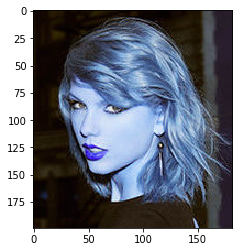

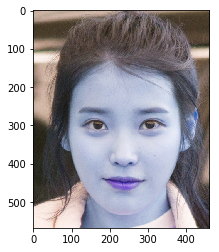

In [23]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

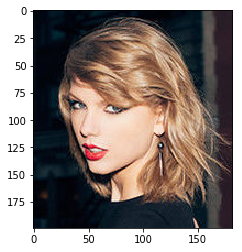

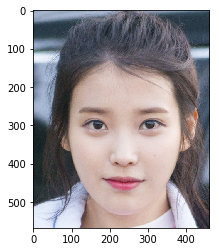

In [24]:
cv_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
cv_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb1)
plt.show()
plt.imshow(cv_rgb2)
plt.show()

In [25]:
im1 = cv2.resize(im1, (im1.shape[1] * SCALE_FACTOR, im1.shape[0] * SCALE_FACTOR))
im2 = cv2.resize(im2, (im2.shape[1] * SCALE_FACTOR, im2.shape[0] * SCALE_FACTOR)) 

# Get Face KeyPoint

In [26]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

In [27]:
rects1 = detector(im1, 1)
rects2 = detector(im2, 1)

if len(rects1 or rects2) > 1:
    raise TooManyFaces
if len(rects1 or rects2) == 0:
    raise NoFaces
     
landmarks1 = numpy.matrix([[p.x, p.y] for p in predictor(im1, rects1[0]).parts()])
landmarks2 = numpy.matrix([[p.x, p.y] for p in predictor(im2, rects2[0]).parts()])

landmarks1.size, landmarks2.size
136/2

68.0

# Annotate KeyPoint

In [28]:
def annotate_landmarks1(im1, landmarks1):
    im1 = im1.copy()
    for idx, point in enumerate(landmarks1):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im1, str(idx), pos, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.3, color=(0, 0, 255))
        cv2.circle(im1, pos, 2, color=(0, 255, 255))
    return im1

In [29]:
im1_annotated = annotate_landmarks1(im1, landmarks1)

In [30]:
cv2.imwrite('image1-landmark.png', im1_annotated)

True

In [31]:
def annotate_landmarks2(im2, landmarks2):
    im2 = im2.copy()
    for idx, point in enumerate(landmarks2):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im2, str(idx), pos, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=0.3, color=(0, 0, 255))
        cv2.circle(im2, pos, 2, color=(0, 255, 255))
    return im2

In [32]:
im2_annotated = annotate_landmarks2(im2, landmarks2)

In [33]:
cv2.imwrite('image2-landmark.png', im2_annotated)

True

In [34]:
keypoint_image1 = cv2.imread('image1-landmark.png')
keypoint_image2 = cv2.imread('image2-landmark.png')

keypoint_image1 = cv2.cvtColor(keypoint_image1, cv2.COLOR_BGR2RGB)
keypoint_image2 = cv2.cvtColor(keypoint_image2, cv2.COLOR_BGR2RGB)

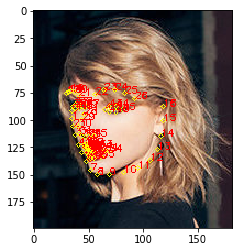

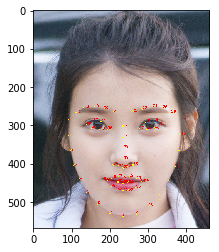

In [35]:
plt.imshow(keypoint_image1)
plt.show()
plt.imshow(keypoint_image2)
plt.show()

# Transformation from points

In [8]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)
    
    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2
    
    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R, c2.T - (s2 / s1) * R * c1.T)), numpy.matrix([0., 0., 1.])])

In [9]:
M = transformation_from_points(landmarks1[ALIGN_POINTS], landmarks2[ALIGN_POINTS])

NameError: name 'landmarks1' is not defined

# Get face mask

In [10]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

In [11]:
def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im, landmarks[group], color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

In [12]:
mask = get_face_mask(im2, landmarks2)

NameError: name 'landmarks2' is not defined

# Warp Image

In [13]:
def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

In [14]:
warped_mask = warp_im(mask, M, im1.shape)

NameError: name 'mask' is not defined

# Correct_colours

In [15]:
def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

In [16]:
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

NameError: name 'landmarks1' is not defined

In [17]:
warped_im2 = warp_im(im2, M, im1.shape)

NameError: name 'M' is not defined

In [18]:
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

NameError: name 'warped_im2' is not defined

In [19]:
output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

NameError: name 'combined_mask' is not defined

In [20]:
cv2.imwrite('output.png', output_im)

NameError: name 'output_im' is not defined

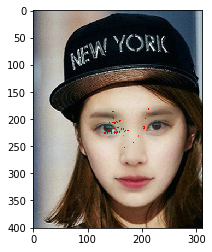

In [21]:
output_image = cv2.imread('output.png')
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.show()